notebook runnable in colab

In [1]:
!git clone https://github.com/sosamandara/token_reduction_nlp.git

Cloning into 'token_reduction_nlp'...
remote: Enumerating objects: 301, done.
remote: Counting objects: 100% (301/301), done.
remote: Compressing objects: 100% (255/255), done.
remote: Total 301 (delta 72), reused 265 (delta 41), pack-reused 0
Receiving objects: 100% (301/301), 12.60 MiB | 5.44 MiB/s, done.
Resolving deltas: 100% (72/72), done.


In [2]:
%cd /content/token_reduction_nlp/notebooks

/content/token_reduction_nlp/notebooks


# Time and Flops

In [ ]:
import sys
import os

# Get the current working directory
current_dir = os.getcwd()

# Assuming the notebooks are in the notebooks directory and executed from there
project_root = os.path.abspath(os.path.join(current_dir, '..'))

# Add the models and src directories to the Python path
models_dir = os.path.join(project_root, 'models')
src_dir = os.path.join(project_root, 'src')

sys.path.append(models_dir)
sys.path.append(src_dir)

# Verify that the paths are correctly added
print("Current directory:", current_dir)
print("Project root directory:", project_root)
print("Models directory added to sys.path:", models_dir in sys.path)
print("Src directory added to sys.path:", src_dir in sys.path)

In [ ]:
!pip install datasets
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config, AutoTokenizer, AutoModel
from modeling_topK_gpt2 import CustomGPT2LMHeadModel
import json
import matplotlib.pyplot as plt
from datasets import load_dataset
from functions import run_generation_on_dataset, plot_averages, load_custom_model
from perplexity import evaluate_perplexity
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

In [4]:
dataset = load_dataset("ag_news")
dataset

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

# Run and save the files

In [5]:
def calculate_reduction(lenght, mask):
  actual_lenght=lenght
  for percentage in mask:
    actual_lenght = (actual_lenght - int(actual_lenght*percentage))
  return actual_lenght + 1

window_sizes = [50, 100, 200, 300, 500, 1000]
remaining_tokens = []
per_keep = []

mask_10 = [0.0, 0.15, 0.2, 0.2, 0.25, 0.25, 0.25, 0.25, 0.25, 0.2, 0.05, 0.05]
mask_20 = [0.0, 0.0, 0.25, 0.2, 0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.0, 0.05]
mask_30 = [0.0, 0.0, 0.2, 0.15, 0.15, 0.15, 0.2, 0.2, 0.05, 0.05, 0.0, 0.0]
mask_40 = [0.0, 0.0, 0.0, 0.2, 0.2, 0.15, 0.1, 0.1, 0.05, 0.05, 0.0, 0.05]
mask_50 = [0.0, 0.0, 0.0, 0.2, 0.15, 0.07, 0.07, 0.1, 0.05, 0.05, 0.0, 0.0]
mask_60 = [0.0, 0.0, 0.07, 0.07, 0.1, 0.07, 0.07, 0.05, 0.05, 0.05, 0.0, 0.0]
mask_70 = [0.0, 0.0, 0.05, 0.07, 0.1, 0.07, 0.05, 0.0, 0.0, 0.05, 0.0, 0.0]
mask_80 = [0.0, 0.0, 0.0, 0.05, 0.05, 0.05, 0.05, 0.05, 0.0, 0.0, 0.0, 0.0]
mask_90 = [0.0, 0.0, 0.0, 0.05, 0.0, 0.05, 0.0, 0.03, 0.0, 0.0, 0.0, 0.0]

masks = [mask_10, mask_20, mask_30, mask_40, mask_50,
         mask_60, mask_70, mask_80, mask_90,]
mask_number = ["10", "20", "30", "40", "50", "60", "70", "80", "90"]

for i, mask in enumerate(masks):
  #remaining_tokens = []
  per_keep = []
  for w in window_sizes:
    #remaining_tokens.append(calculate_reduction(w, mask))
    per_keep.append(round(calculate_reduction(w, mask)/w,2))
    #print(remaining_tokens)
  print("-----",mask_number[i],"-----")
  print(per_keep)

----- 10 -----
[0.14, 0.13, 0.1, 0.1, 0.1, 0.1]
----- 20 -----
[0.24, 0.22, 0.2, 0.2, 0.19, 0.19]
----- 30 -----
[0.34, 0.31, 0.29, 0.3, 0.29, 0.29]
----- 40 -----
[0.44, 0.4, 0.4, 0.39, 0.38, 0.38]
----- 50 -----
[0.52, 0.51, 0.49, 0.49, 0.48, 0.48]
----- 60 -----
[0.68, 0.61, 0.59, 0.59, 0.58, 0.58]
----- 70 -----
[0.76, 0.71, 0.68, 0.68, 0.67, 0.67]
----- 80 -----
[0.82, 0.8, 0.79, 0.78, 0.78, 0.78]
----- 90 -----
[0.92, 0.9, 0.89, 0.88, 0.88, 0.88]


In [ ]:
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
config = GPT2Config.from_pretrained(model_name)
model_gpt = GPT2LMHeadModel.from_pretrained(model_name, config=config).to('cuda')

# Layers to prune
layers_to_prune = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

# Load custom models with different k_percent values
custom_models = {}
for i, mask in enumerate(masks):
    model_id = f"random_{i * 10 + 10}"
    custom_models[model_id] = load_custom_model(model_name, config, mask, selection_method="top_k", layers_to_prune=layers_to_prune)

In [ ]:
models = [model_gpt] + list(custom_models.values())
model_names = ['gpt2'] + [f'top_K_{i * 10}%' for i in range(1, len(custom_models) + 1)]
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
output_dir = os.path.join(project_root, 'results/Time_Flops_Mean_Removal')

for i, model in enumerate(models):
  results_gpt = run_generation_on_dataset(dataset, model, tokenizer, 10, [10, 20, 30, 50, 100, 200, 300],
                                          model_names[i], output_dir)

Plotting time_taken for model gpt2 with 70 results
gpt2 averages: [0.14181230068206788, 0.3287815093994141, 0.5960782051086426, 1.1456620693206787, 2.4550694465637206, 6.385976696014405, 18.70413637161255]
Plotting time_taken for model top_K_10% with 70 results
top_K_10% averages: [0.177003812789917, 0.3670575380325317, 0.5895724534988404, 0.9796058416366578, 2.159143400192261, 5.167164397239685, 8.663120102882385]
Plotting time_taken for model top_K_20% with 70 results
top_K_20% averages: [0.17960762977600098, 0.3660648107528687, 0.583067798614502, 0.988793921470642, 2.2186487913131714, 5.117498970031738, 8.345954823493958]
Plotting time_taken for model top_K_30 with 70 results
top_K_30 averages: [0.3121568918228149, 0.38366851806640623, 0.5854240655899048, 1.0665192127227783, 2.4414942026138307, 5.5736347198486325, 9.468899583816528]
Plotting time_taken for model top_K_40% with 70 results
top_K_40% averages: [0.184982967376709, 0.3934487819671631, 0.6151030540466309, 1.10806577205657

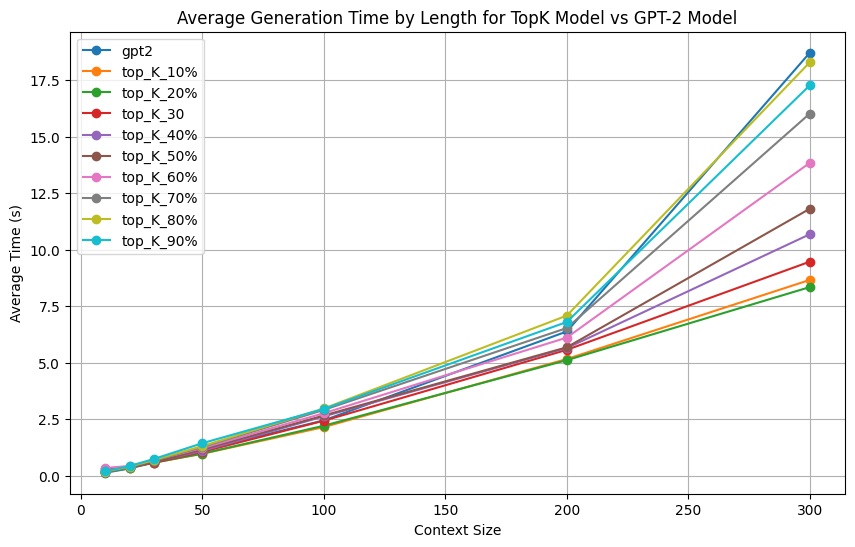

Plotting flops for model gpt2 with 70 results
gpt2 averages: [147428703283.2, 368418341222.4, 742699906560.0, 1749555041894.4, 5449512960000.0, 18967716864000.0, 49729222656000.0]
Plotting flops for model top_K_10% with 70 results
top_K_10% averages: [49483315507.2, 121557564979.2, 240112496640.0, 542045445734.4, 1615621374873.6, 5475410565120.0, 14174806443417.6]
Plotting flops for model top_K_20% with 70 results
top_K_20% averages: [61809568204.8, 152219682508.8, 288295891507.2, 635088944947.2, 1869332102553.6, 6242770253260.8, 16021592636620.8]
Plotting flops for model top_K_30 with 70 results
top_K_30 averages: [73434641664.0, 179106495129.6, 347560182988.8, 789896500224.0, 2390788705382.4, 8158562621644.8, 21122067841996.8]
Plotting flops for model top_K_40% with 70 results
top_K_40% averages: [86036829235.2, 213646263244.8, 421942779187.2, 975557696256.0, 2917138057574.4, 9839656788787.2, 25370707221504.0]
Plotting flops for model top_K_50% with 70 results
top_K_50% averages: [96

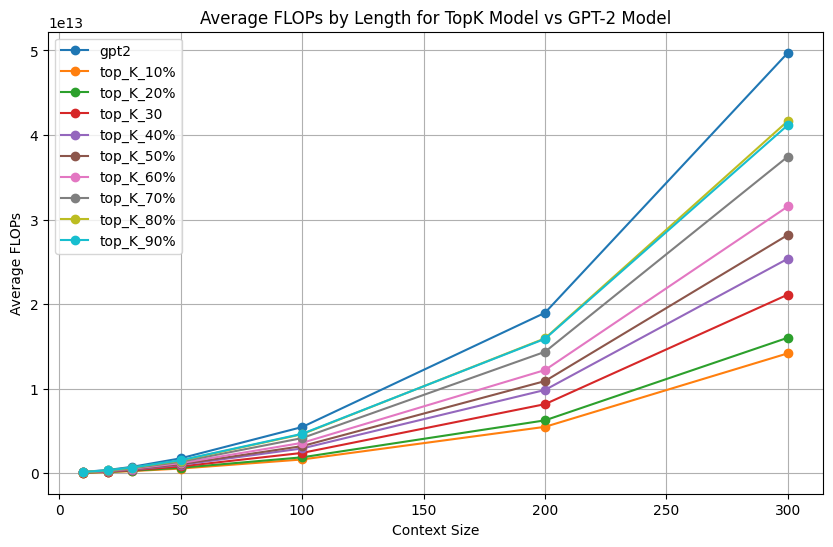

In [6]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np

def plot_averages(results, key, ylabel, title, figsize=(10, 6)):
    lengths = sorted(list(set([res['lengths'] for res in results])))
    model_names = sorted(list(set([res['model_name'] for res in results])))

    plt.figure(figsize=figsize)

    for model_name in model_names:
        model_results = [res for res in results if res['model_name'] == model_name]
        print(f"Plotting {key} for model {model_name} with {len(model_results)} results")
        averages = []
        for length in lengths:
            length_results = [res[key] for res in model_results if res['lengths'] == length]
            if length_results:
                averages.append(np.mean(length_results))
            else:
                averages.append(float('nan'))  # Handle cases where there are no results for a specific length
        print(f"{model_name} averages: {averages}")
        plt.plot(lengths, averages, label=model_name, marker='o')

    plt.xlabel('Context Size')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

def load_results_from_json(model_names, results_dir):
    all_results = []
    for model_name in model_names:
        #print(model_name)
        json_filename = f'generation_results_{model_name}.json'
        json_path = os.path.join(results_dir, json_filename)
        if not os.path.exists(json_path):
            #print(f"File not found: {json_path}")
            continue
        with open(json_path, 'r') as f:
            model_results = json.load(f)
            #print(f"Loaded {len(model_results)} results for model {model_name}")
            all_results.extend(model_results)
    return all_results

# Define model names and paths
model_names = ['gpt2', 'top_K_10%', 'top_K_20%', 'top_K_30%', 'top_K_40%', 'top_K_50%', 'top_K_60%', 'top_K_70%', 'top_K_80%', 'top_K_90%']
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
results_dir = os.path.join(project_root, 'results/Time_Flops_Mean_Removal')

# Load all results
all_results = load_results_from_json(model_names, results_dir)

# Plot average times
plot_averages(all_results, key="time_taken", ylabel='Average Time (s)', title='Average Generation Time by Length for TopK Model vs GPT-2 Model')

# Plot average FLOPs
plot_averages(all_results, key="flops", ylabel='Average FLOPs', title='Average FLOPs by Length for TopK Model vs GPT-2 Model')


# Obtain metrics

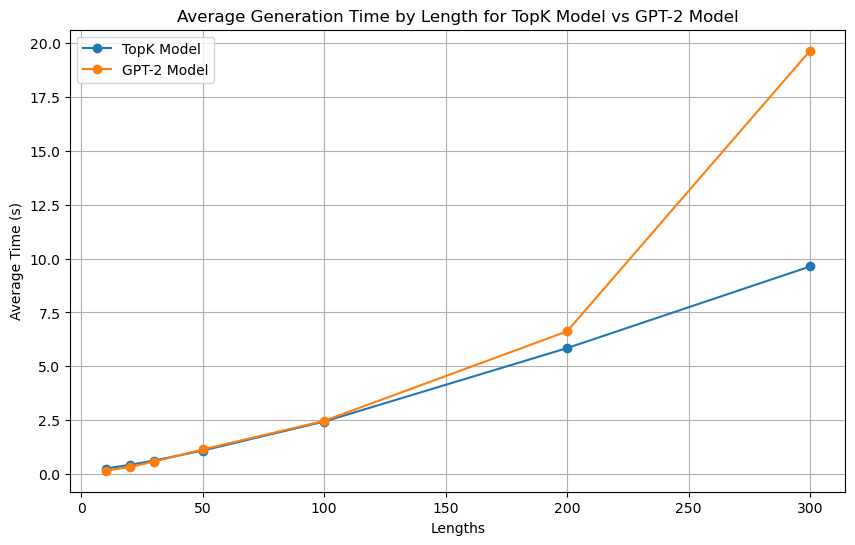

In [ ]:
# Construct the paths to the JSON files
project_root = os.path.abspath(os.path.join(current_dir, '..'))
results_dir = os.path.join(project_root, 'results/Mean_Attention_Removal')

custom_model_path = os.path.join(results_dir, 'generation_results_custom_model_50_with_flops.json')
gpt2_model_path = os.path.join(results_dir, 'generation_results_model_gpt_2_50_with_flops.json')

# Load the results from JSON files
with open(custom_model_path, 'r') as f:
    custom_model_results = json.load(f)

with open(gpt2_model_path, 'r') as f:
    gpt2_model_results = json.load(f)

figsize = (10, 6)

# plot average times
plot_averages(custom_model_results, gpt2_model_results, key="time_taken", ylabel='Average Time (s)', title='Average Generation Time by Length for TopK Model vs GPT-2 Model', figsize=figsize)

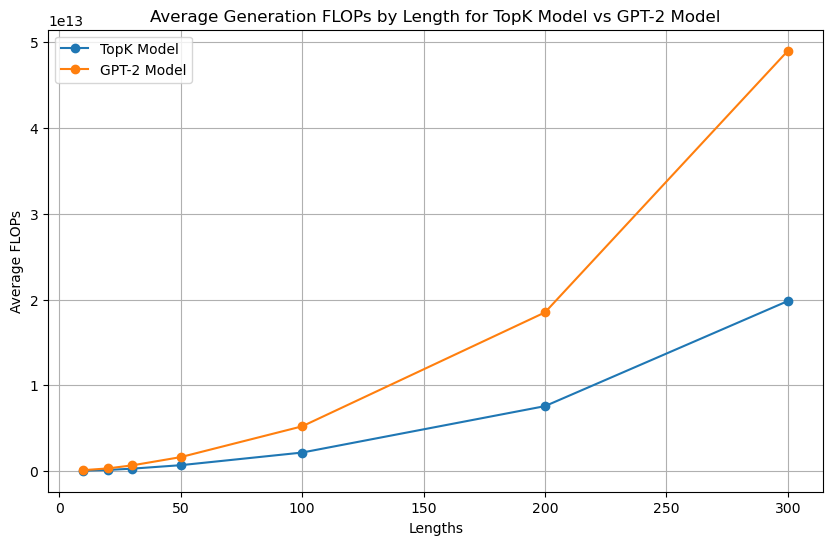

In [ ]:
# plot average FLOPs
plot_averages(custom_model_results, gpt2_model_results, key="flops", ylabel='Average FLOPs', title='Average Generation FLOPs by Length for TopK Model vs GPT-2 Model', figsize=figsize)

# BertScore

In [ ]:
# initialize BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')

# function to get BERT embeddings
def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.detach().numpy()

gpt2_generated_embeddings = []
custom_generated_embeddings = []

for result in gpt2_model_results:
    generated_text = result['generated_text']
    embedding = get_bert_embeddings(generated_text)
    gpt2_generated_embeddings.append(embedding)

for result in custom_model_results:
    generated_text = result['generated_text']
    embedding = get_bert_embeddings(generated_text)
    custom_generated_embeddings.append(embedding)

gpt2_generated_embeddings = np.vstack(gpt2_generated_embeddings)
custom_generated_embeddings = np.vstack(custom_generated_embeddings)

similarities = []

for gpt2_emb, custom_emb in zip(gpt2_generated_embeddings, custom_generated_embeddings):
    similarity = cosine_similarity([gpt2_emb], [custom_emb]).mean()
    similarities.append(similarity)

average_similarity = np.mean(similarities)
average_similarity

0.76342946

# bert_score

In [ ]:
!pip install transformers torch bert_score

In [ ]:
from bert_score import score

gpt2_generated_texts = [result['generated_text'] for result in gpt2_model_results]
custom_generated_texts = [result['generated_text'] for result in custom_model_results]

# BERTScore
P, R, F1 = score(gpt2_generated_texts, custom_generated_texts, lang="en", verbose=True)

# average BERTScores
average_precision = P.mean().item()
average_recall = R.mean().item()
average_f1 = F1.mean().item()

print(f"Average Precision: {average_precision}")
print(f"Average Recall: {average_recall}")
print(f"Average F1: {average_f1}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/11 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/6 [00:00<?, ?it/s]

done in 26.93 seconds, 13.00 sentences/sec
Average Precision: 0.8391859531402588
Average Recall: 0.8304443359375
Average F1: 0.8344979286193848


# ROGUE Score

In [ ]:
!pip install rouge-score

In [ ]:
from rouge_score import rouge_scorer

gpt2_texts = [result['generated_text'] for result in gpt2_model_results]
custom_texts = [result['generated_text'] for result in custom_model_results]

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# compute ROUGE scores
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

for gpt2_text, custom_text in zip(gpt2_texts, custom_texts):
    scores = scorer.score(gpt2_text, custom_text)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# average ROUGE scores
average_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
average_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
average_rougeL = sum(rougeL_scores) / len(rougeL_scores)

print("Average ROUGE-1 Score:", round(average_rouge1,2))
print("Average ROUGE-2 Score:", round(average_rouge2,2))
print("Average ROUGE-L Score:", round(average_rougeL,2))

Average ROUGE-1 Score: 0.3
Average ROUGE-2 Score: 0.14
Average ROUGE-L Score: 0.27


In [ ]:
# Load the datasets
with open(gpt2_model_path, 'r') as f:
    gpt2_results = json.load(f)

with open(custom_model_path, 'r') as f:
    custom_results = json.load(f)

# Filter out results with lengths 100, 200, and 300
filtered_gpt2_results = [result for result in gpt2_results if result['lengths'] not in [50,100, 200, 300]]
filtered_custom_results = [result for result in custom_results if result['lengths'] not in [50,100, 200, 300]]

# Extract generated texts from the filtered results
filtered_gpt2_texts = [result['generated_text'] for result in filtered_gpt2_results]
filtered_custom_texts = [result['generated_text'] for result in filtered_custom_results]

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Compute ROUGE scores
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

for gpt2_text, custom_text in zip(filtered_gpt2_texts, filtered_custom_texts):
    scores = scorer.score(gpt2_text, custom_text)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# Calculate average ROUGE scores
average_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
average_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
average_rougeL = sum(rougeL_scores) / len(rougeL_scores)

print("Average ROUGE-1 Score:", round(average_rouge1,2))
print("Average ROUGE-2 Score:", round(average_rouge2,2))
print("Average ROUGE-L Score:", round(average_rougeL,2))

Average ROUGE-1 Score: 0.36
Average ROUGE-2 Score: 0.2
Average ROUGE-L Score: 0.34


# Perplexity

Reference: https://huggingface.co/docs/transformers/perplexity

In [ ]:
test = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")
encodings = tokenizer("\n\n".join(test["text"]), return_tensors="pt")

In [ ]:
log_probs_gpt2 = evaluate_perplexity(model_gpt, encodings, 20)
# Calculate final perplexity
avg_log_prob_gpt2 = np.mean(log_probs_gpt2)
perplexity_gpt2 = np.exp(-avg_log_prob_gpt2)

print("Final Perplexity:", perplexity_gpt2)

In [ ]:
perplexity_gpt2

33.47348659116395

In [ ]:
df = pd.DataFrame(log_probs_gpt2, columns=["log_prob"])

# Save to CSV
file_path = "results/Mean_Attention_Removal/log_probs_gpt2.csv"
df.to_csv(file_path, index=False)

In [ ]:
log_probs_topK = evaluate_perplexity(custom_model, encodings, 20)
# Calculate final perplexity
avg_log_probs_topK = np.mean(log_probs_topK)
perplexity_topK = np.exp(-avg_log_probs_topK)

print("Final Perplexity:", perplexity_topK)

In [ ]:
perplexity_topK

48.890736229323025

In [ ]:
df = pd.DataFrame(log_probs_topK, columns=["log_prob"])

# Save to CSV
file_path = "results/Mean_Attention_Removal/log_probs_topK.csv"
df.to_csv(file_path, index=False)